In [87]:
from pathlib import Path
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
from tqdm.auto import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from sklearn.cluster import KMeans
import utils
import sys
import os
import numpy as np
from environment import CONTEXTS_LABELS
#from agent import neural_network
import seaborn as sns
from agent import DQN
import pandas as pd
from scipy.spatial.distance import pdist

In [88]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
save_path = Path("save")
save_path.exists()

True

## Data Folder

In [90]:
data_dir = save_path / "6-30-EW"
data_dir.exists()

True

In [91]:
data_path = data_dir / "data copy.tar"
data_path.exists()

True

In [92]:
data_dict = torch.load(data_path, weights_only=False, map_location=DEVICE)
data_dict.keys()

dict_keys(['rewards', 'steps', 'episodes', 'all_states', 'all_actions', 'all_qvalues', 'losses', 'p', 'epsilons', 'weights_val_stats', 'biases_val_stats', 'weights_grad_stats', 'biases_grad_stats', 'net', 'env', 'weights', 'biases'])

In [93]:
parameters = data_dict['p']
n_observations = parameters.n_observations
n_actions = parameters.n_actions
n_units = parameters.n_hidden_units

In [94]:
model = DQN(n_observations, n_actions, n_units)

## QQ Plots over Agents

In [95]:
# Helper Function for getting cluster nodes

def get_cluster_members(Z, cluster_idx, n_leaves):
    """Returns the leaf indices in a cluster"""
    if cluster_idx < n_leaves:
        return [int(cluster_idx)]
    else:
        c1, c2 = int(Z[cluster_idx - n_leaves][0]), int(Z[cluster_idx - n_leaves][1])
        return get_cluster_members(Z, c1, n_leaves) + get_cluster_members(Z, c2, n_leaves)

In [121]:
all_cluster_dfs = {}

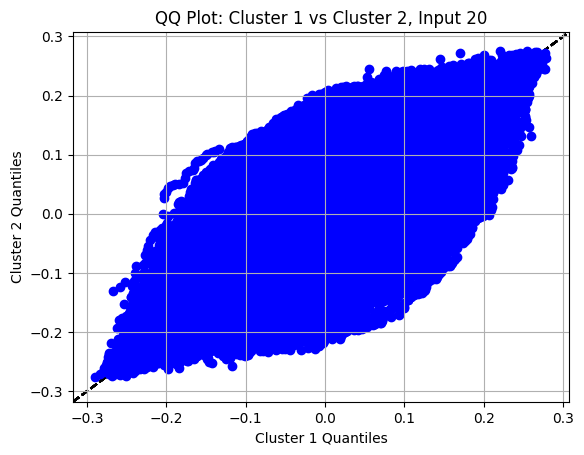

In [173]:
num_agents = 90
layer = 0 # which layer you want to look at
#node_idx = 2 # which node you want to look at
incoming = True # whether you want to cluster based on incoming or outgoing weights
cluster_idx = 508 # which cluster joining you want to look at ; 510 is the top ; 509 would be one side, 508 the other

rmse_df_508 = pd.DataFrame() # DataFrame to store RMSE for each input -- each QQ plot has an RMSE -- measures quantile differences

for node_idx in range(21):

    rmse_list = []

    for i in range(num_agents):
        
        # Loading Agent Model
        model_path = data_dir / f'trained-agent-state-{i}.pt'
        model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
        model.eval()

        # Extracting Model Weights
        state_dict = model.state_dict()
        layer0_weights = state_dict['mlp.0.weight']
        layer1_weights = state_dict['mlp.1.weight']
        layer2_weights = state_dict['mlp.3.weight']
        layer3_weights = state_dict['mlp.5.weight']
        layer4_weights = state_dict['mlp.7.weight']
        weights = [layer0_weights,layer1_weights,layer2_weights,layer3_weights,layer4_weights]

        # Perform Hierarchical Clustering for Agent Weights
        if incoming:
            W = weights[layer].detach().numpy()
        else:
            W = weights[layer].detach().numpy().T
        distance_matrix = pdist(W, metric='euclidean')
        linked = linkage(distance_matrix, method='ward')
        first_cluster_id = int(linked[cluster_idx][0])
        second_cluster_id = int(linked[cluster_idx][1])

        # Plot dendrogram
        # plt.figure(figsize=(10, 5))
        # dendrogram(linked)
        # plt.title(f"Hierarchical Clustering of Nodes in Layer {layer} - Agent {i}", fontsize=20)
        # plt.xlabel("Node Index", fontsize=15)
        # plt.ylabel("Distance", fontsize=15)
        # plt.savefig('figures/hierclusteringlayer0a3.png', dpi=300)
        # plt.show()

        # Extract Nodes of Each Cluster
        n = W.shape[0]
        first_cluster_nodes = get_cluster_members(linked, first_cluster_id, n)
        cluster_weights = W[first_cluster_nodes]
        cluster_1_weights = [sublist[node_idx] for sublist in cluster_weights]
        second_cluster_nodes = get_cluster_members(linked, second_cluster_id, n)
        cluster_weights = W[second_cluster_nodes]
        cluster_2_weights = [sublist[node_idx] for sublist in cluster_weights]

        # Plot the QQ Plot of Cluster Distributions
        quantiles = np.linspace(0.01, 0.99, 100)
        q0 = np.quantile(cluster_1_weights, quantiles)
        q1 = np.quantile(cluster_2_weights, quantiles)
        plt.scatter(q0, q1, marker='o', color='blue')

        rmse = np.sqrt(np.mean((q1 - q0) ** 2)) # computes quantile difference
        rmse_list.append(rmse)
        
    rmse_df_508[f'Input {node_idx}'] = rmse_list
    all_cluster_dfs['508'] = rmse_df_508

    lims = [
        min(plt.xlim()[0], plt.ylim()[0]),  # smallest of x/y lower limits
        max(plt.xlim()[1], plt.ylim()[1])   # largest of x/y upper limits
    ]
    plt.plot(lims, lims, 'k--', alpha=0.75, zorder=0)  # y = x line
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Cluster 1 Quantiles')
    plt.ylabel('Cluster 2 Quantiles')
    plt.title(f'QQ Plot: Cluster 1 vs Cluster 2, Input {node_idx}')
    plt.grid(True)
    #plt.savefig(f'figures/qqplots{num_agents}i{node_idx}.png', dpi=300)
    #plt.show()

In [172]:
print(linked[509][1])
print(get_cluster_members(linked, 1019, n_leaves=512))
print(linked[510][1])
print(get_cluster_members(linked, 1021, n_leaves=512).index(411))

1019.0
[411, 57, 81, 490, 329, 355, 368, 404, 463, 2, 205, 269, 295, 458, 142, 223, 112, 212, 273, 181, 126, 363, 147, 421, 217, 366, 206, 450, 350, 434, 271, 194, 393, 264, 509, 15, 129, 26, 472, 222, 476, 36, 394, 29, 69, 361, 503, 61, 31, 133, 470, 278, 167, 249, 124, 94, 276, 336, 87, 474, 233, 254, 316, 340, 507, 446, 510, 377, 44, 48, 108, 298, 1, 465, 496, 234, 351, 184, 330, 371, 113, 445, 89, 381, 98, 241, 143, 444, 210, 293, 24, 395, 148, 403, 231, 86, 165, 376, 378, 140, 274, 459, 461, 208, 291, 423, 424, 4, 319, 285, 504, 242, 83, 136, 486, 502, 505, 55, 356, 171, 11, 417, 10, 105, 218, 304, 199, 280, 400, 460, 182, 493, 71, 78, 5, 28, 19, 27, 335, 352, 179, 491, 161, 428, 141, 178, 211, 215, 58, 227, 236, 268, 303, 398, 103, 177, 439, 272, 159, 365, 66, 284, 6, 469]
1021.0
90


In [174]:
all_cluster_dfs

{'510':        Input 0   Input 1   Input 2   Input 3   Input 4   Input 5   Input 6  \
 0     0.110434  0.017230  0.096912  0.009994  0.019320  0.044231  0.022516   
 1     0.064956  0.041828  0.166759  0.039680  0.048181  0.018690  0.046867   
 2     0.055289  0.103913  0.150657  0.021094  0.056620  0.069290  0.019424   
 3     0.017381  0.169485  0.051774  0.038994  0.023222  0.019228  0.032963   
 4     0.126940  0.018811  0.012686  0.024536  0.055508  0.025529  0.019134   
 ...        ...       ...       ...       ...       ...       ...       ...   
 86    0.027882  0.109200  0.144261  0.027039  0.037648  0.019726  0.009111   
 87    0.072280  0.088190  0.141447  0.030938  0.036017  0.015675  0.035317   
 88    0.022500  0.111566  0.074890  0.034026  0.028131  0.022439  0.019368   
 89    0.166193  0.056194  0.041033  0.019001  0.022771  0.034824  0.016222   
 mean  0.107393  0.066652  0.077701  0.029961  0.030624  0.032024  0.030045   
 
        Input 7   Input 8   Input 9  ...  I

### QQ Plots : Distances from Identity Line

In [ ]:
# Example: df with 21 columns
# Assume df is your dataframe

# Columns you want separate
cols_separate = ['Input 0', 'Input 1', 'Input 2']

# Columns to combine
cols_combined = [col for col in rmse_df.columns if col not in cols_separate]

# Combine the 18 columns by stacking their values into one series
combined_values = rmse_df[cols_combined].melt(value_name='value')['value']
combined_odor_values = rmse_df[cols_separate].melt(value_name='value')['value']

# Create DataFrame for combined group
combined_df = pd.DataFrame({
    'group': 'Other 18',
    'value': combined_values
})

combined_odor_df = pd.DataFrame({
    'group': 'Odor Input',
    'value': combined_odor_values
})

# Concatenate all groups into one DataFrame
plot_df = pd.concat([combined_odor_df, combined_df], ignore_index=True)
#print(plot_df.to_string())


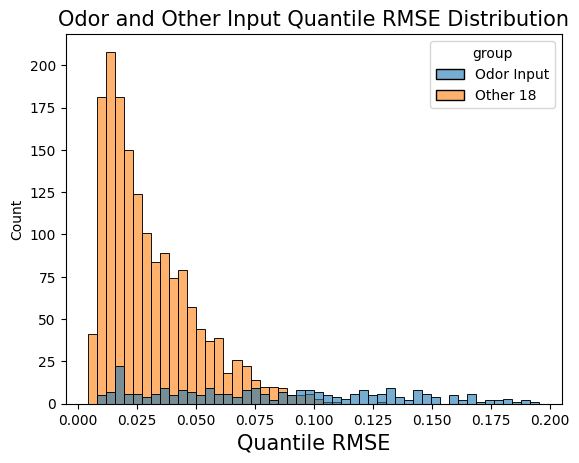

In [67]:
sns.histplot(data=plot_df, x='value', hue='group', common_bins=True, bins=50, alpha=0.6)
plt.title('Odor and Other Input Quantile RMSE Distribution', fontsize=15)
plt.xlabel('Quantile RMSE', fontsize=15)
plt.savefig('figures/inputRMSEdist.png', dpi=300)
plt.show()


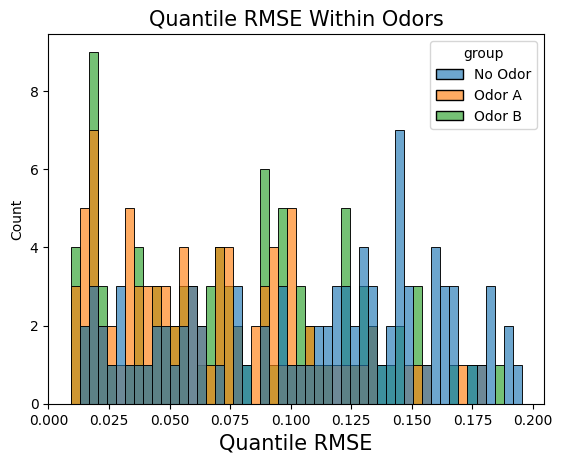

In [85]:
odor_df = rmse_df[cols_separate].melt(var_name='group', value_name='value')
odor_df['group'] = odor_df['group'].replace({
    'Input 0': 'No Odor',
    'Input 1': 'Odor A',
    'Input 2': 'Odor B'
})
plt.xlabel('Quantile RMSE', fontsize=15)
plt.title('Quantile RMSE Within Odors', fontsize=15)
sns.histplot(data=odor_df, x='value', hue='group', common_bins=True, bins=50, alpha=0.65)
plt.savefig('figures/odorRMSEdist.png', dpi=300)

In [128]:
rmse_df_509 = all_cluster_dfs['509']

rmse_df_509.loc['mean'] = rmse_df_509.mean()
print(rmse_df_509.to_string())

       Input 0   Input 1   Input 2   Input 3   Input 4   Input 5   Input 6   Input 7   Input 8   Input 9  Input 10  Input 11  Input 12  Input 13  Input 14  Input 15  Input 16  Input 17  Input 18  Input 19  Input 20
0     0.060666  0.150819  0.048758  0.014736  0.020999  0.017996  0.118282  0.016293  0.021960  0.067503  0.060635  0.065036  0.062504  0.021760  0.039327  0.037565  0.044065  0.048195  0.043264  0.032756  0.050611
1     0.170602  0.146865  0.012890  0.025205  0.026562  0.030858  0.016210  0.019324  0.020678  0.012537  0.046746  0.123347  0.013975  0.070929  0.057456  0.021123  0.062019  0.020424  0.034095  0.026523  0.012996
2     0.026004  0.019793  0.043440  0.060592  0.099724  0.038009  0.008032  0.008419  0.062222  0.032065  0.096779  0.016890  0.043830  0.059211  0.048356  0.045870  0.016453  0.024985  0.086581  0.024108  0.051977
3     0.146689  0.099866  0.050512  0.026873  0.011616  0.082980  0.020225  0.015251  0.035206  0.038519  0.044381  0.076740  0.050019  0.04

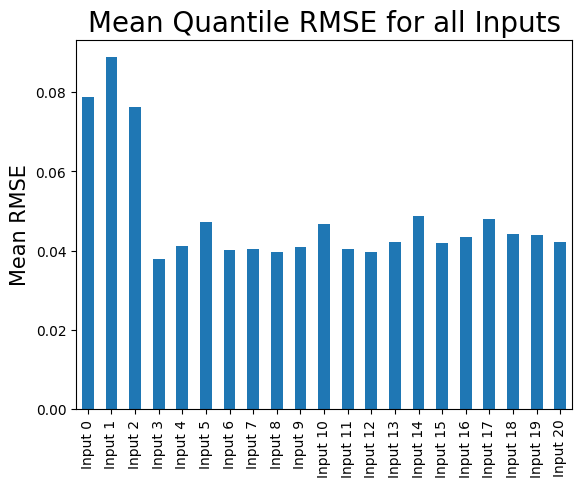

In [ ]:
mean_values = rmse_df_509.loc['mean']
mean_values.plot(kind='bar')
plt.ylabel('Mean RMSE', fontsize=15)
plt.title('Mean Quantile RMSE for all Inputs', fontsize=20)
#plt.savefig('figures/meanquantrmse.png', dpi=300)

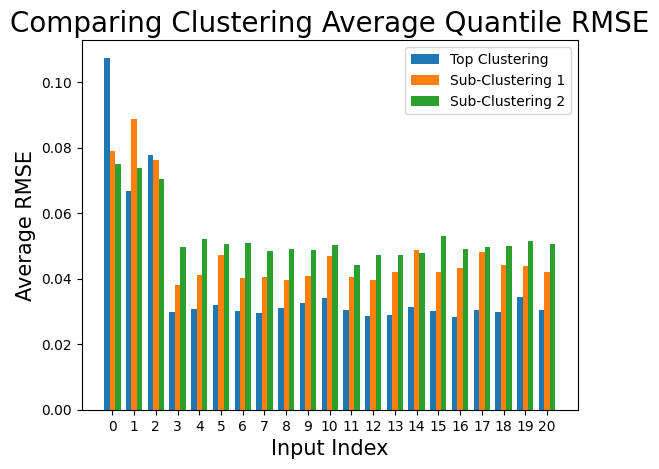

In [186]:
rmse_df_510 = all_cluster_dfs['510']
rmse_df_510.loc['mean'] = rmse_df_510.mean()
mean_values_510 = rmse_df_510.loc['mean']

rmse_df_509 = all_cluster_dfs['509']
rmse_df_509.loc['mean'] = rmse_df_509.mean()
mean_values_509 = rmse_df_509.loc['mean']

rmse_df_508 = all_cluster_dfs['508']
rmse_df_508.loc['mean'] = rmse_df_508.mean()
mean_values_508 = rmse_df_508.loc['mean']


labels = list(mean_values_510.keys())
x = np.arange(len(labels))  # label locations
width = 0.25  # width of the bars

s1 = pd.Series(mean_values_510)
s2 = pd.Series(mean_values_509)
s3 = pd.Series(mean_values_508)

plt.bar(x - width, s1.values, width, label='Top Clustering')
plt.bar(x, s2.values, width, label='Sub-Clustering 1')
plt.bar(x + width, s3.values, width, label='Sub-Clustering 2')

plt.xticks(x)
plt.title('Comparing Clustering Average Quantile RMSE', fontsize=20)
plt.ylabel('Average RMSE', fontsize=15)
plt.xlabel('Input Index', fontsize=15)
plt.legend()
#plt.tight_layout()
plt.savefig('figures/compareclusteringavgquant.png', dpi=300, bbox_inches='tight')
plt.show()
